In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    y_train, y_test = y_train.flatten(), y_test.flatten()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training data shape: (50000, 32, 32, 3), Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


In [ ]:

def create_triplets(x, y, num_triplets=10000):
    triplets = []
    num_classes = 100
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for _ in range(num_triplets):
        anchor_label = random.randint(0, num_classes - 1)
        anchor_idx = random.choice(digit_indices[anchor_label])
        positive_idx = random.choice(digit_indices[anchor_label])

        negative_label = random.randint(0, num_classes - 1)
        while negative_label == anchor_label:
            negative_label = random.randint(0, num_classes - 1)
        negative_idx = random.choice(digit_indices[negative_label])

        triplets.append((x[anchor_idx], x[positive_idx], x[negative_idx]))

    return np.array(triplets)


triplets_train = create_triplets(x_train, y_train, num_triplets=20000)
triplets_test = create_triplets(x_test, y_test, num_triplets=5000)
print(f"Generated {len(triplets_train)} training triplets and {len(triplets_test)} test triplets.")


Generated 20000 training triplets and 5000 test triplets.


In [ ]:
def create_siamese_network(input_shape):
    base_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(base_input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return models.Model(base_input, x)

input_shape = x_train.shape[1:]  # CIFAR-100 input shape
base_model = create_siamese_network(input_shape)
base_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,206,464 (8.42 MB)

 Trainable params: 2,206,208 (8.42 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
class TripletStack(layers.Layer):
    def call(self, inputs):
        anchor, positive, negative = inputs
        return tf.stack([anchor, positive, negative], axis=1)

def create_triplet_model(input_shape):
    base_model = create_siamese_network(input_shape)

    input_anchor = layers.Input(shape=input_shape)
    input_positive = layers.Input(shape=input_shape)
    input_negative = layers.Input(shape=input_shape)

    embedding_anchor = base_model(input_anchor)
    embedding_positive = base_model(input_positive)
    embedding_negative = base_model(input_negative)

    stacked_embeddings = TripletStack()([embedding_anchor, embedding_positive, embedding_negative])
    model = models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=stacked_embeddings)
    return model

triplet_model = create_triplet_model(input_shape)
triplet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 128)            │      2,206,464 │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0],   │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ triplet_stack             │ (None, 3, 128)         │              0 │ functional_1[0][0],    │
│ (TripletStack)            │                        │                │ functional_1[1][0],    │
│                           │                        │                │ functional_1[2][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,206,464 (8.42 MB)

 Trainable params: 2,206,208 (8.42 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
def triplet_loss(y_true, y_pred, margin=0.2):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    return tf.reduce_mean(tf.maximum(positive_distance - negative_distance + margin, 0))

def train_model(model, triplets_train, triplets_test, epochs=10, batch_size=64):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=triplet_loss)
    history = model.fit(
        [triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]],
        np.zeros(len(triplets_train)),  # Dummy labels
        validation_data=([triplets_test[:, 0], triplets_test[:, 1], triplets_test[:, 2]],
                         np.zeros(len(triplets_test))),
        epochs=epochs,
        batch_size=batch_size
    )
    return history


history = train_model(triplet_model, triplets_train, triplets_test)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 6.2929 - val_loss: 0.1992
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1865 - val_loss: 0.1700
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1764 - val_loss: 0.1676
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1742 - val_loss: 0.1765
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1722 - val_loss: 0.1659
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1713 - val_loss: 0.1640
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1671 - val_loss: 0.1658
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1701 - val_loss: 0.1637
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1654 - val_loss: 0.1624
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1658 - val_loss: 0.1649


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


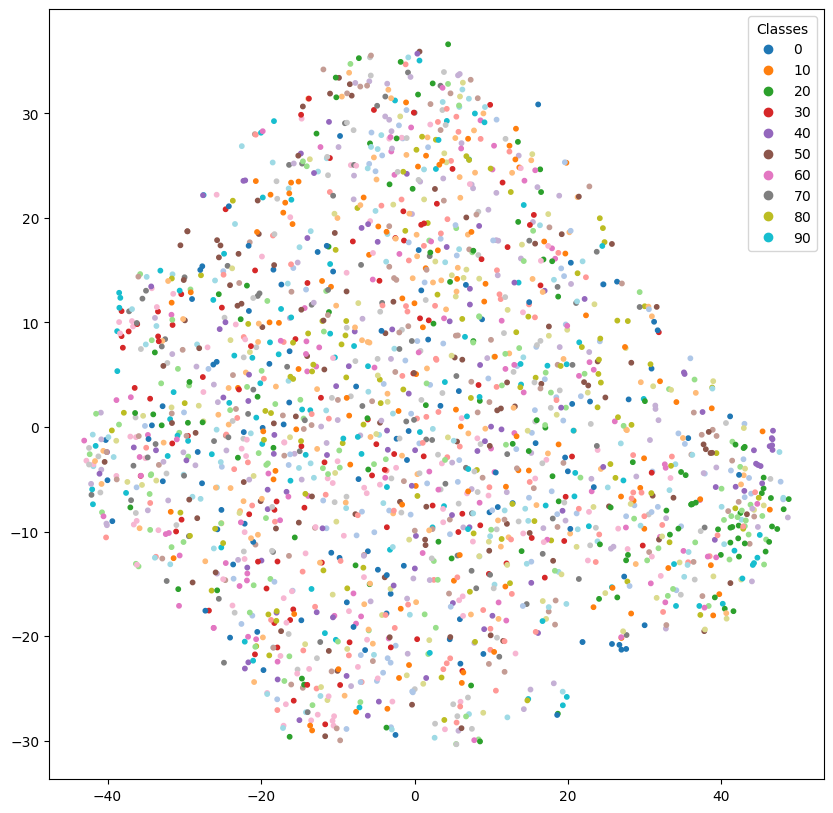

In [ ]:
def visualize_embeddings(base_model, x, y):
    embeddings = base_model.predict(x)
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y, cmap='tab20', s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()


visualize_embeddings(base_model, x_test[:2000], y_test[:2000])


In [8]:
def compute_distance(embedding_a, embedding_b):
    return np.linalg.norm(embedding_a - embedding_b, axis=-1)

def retrieve_top_matches(base_model, x_test, y_test, query_index, top_k=5):
    embeddings = base_model.predict(x_test)
    query_embedding = embeddings[query_index]
    distances = np.array([compute_distance(query_embedding, e) for e in embeddings])
    sorted_indices = np.argsort(distances)
    top_matches = sorted_indices[:top_k + 1]
    return top_matches[1:], distances[top_matches[1:]]

def evaluate_similarity(base_model, x_test, y_test, top_k=5, num_queries=100):
    precision_list, recall_list, accuracy_list = [], [], []

    for query_index in np.random.choice(len(x_test), num_queries, replace=False):
        query_label = y_test[query_index]
        top_matches, _ = retrieve_top_matches(base_model, x_test, y_test, query_index, top_k)
        top_labels = y_test[top_matches]

        relevant_matches = np.sum(top_labels == query_label)
        precision = relevant_matches / top_k
        recall = relevant_matches / np.sum(y_test == query_label)
        accuracy = int(query_label in top_labels)

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)

    return (
        np.mean(precision_list),
        np.mean(recall_list),
        np.mean(accuracy_list)
    )

precision, recall, accuracy = evaluate_similarity(base_model, x_test[:2000], y_test[:2000], top_k=5)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━